<a href="https://colab.research.google.com/github/Snailpong/GAN_MRI_3D_Super_Resolution/blob/main/SRCNN_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Requirements install**




In [3]:
!pip install nibabel tqdm scikit-image

# **Import package**

In [1]:
import os
import sys
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.ndimage import zoom

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable

# **Drive mount**

In [2]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks'

print("MY_GOOGLE_DRIVE_PATH: ", MY_GOOGLE_DRIVE_PATH)
# In case we haven't created the folder already; we will create a folder in the project path  
%cd "{MY_GOOGLE_DRIVE_PATH}"

/content/drive
Mounted at /content/drive
MY_GOOGLE_DRIVE_PATH:  /content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks


# **Model Definition**

In [18]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 9, padding=4),
            nn.ReLU(),
            nn.Conv2d(64, 32, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 5, padding=2)
        )

    def forward(self, x):
        return self.layers(x)

# **Image processing**

In [65]:
def preprocessing(image_name_raw):
    raw_image = nib.load(image_name_raw)
    raw_array = np.array(raw_image.get_fdata(), dtype=np.float32)
    clip_value = np.sort(raw_array.ravel())[int(np.prod(raw_array.shape) * 0.999)]
    clipped_image = np.clip(raw_array, 0, clip_value)

    H, W, D = clipped_image.shape
    cropped_image = clipped_image[:H - H%3, :W - W%3, : D - D%3]
    image = cropped_image / cropped_image.max()

    return image

In [63]:
def get_lr(image):
    downscaled_lr = zoom(image, 1/3.0, order=2, prefilter=False)
    lr = np.clip(zoom(downscaled_lr, 3, order=2, prefilter=False), 0, image.max())
    return lr

# **DataLoader implementation**

In [64]:
class BrainDataset(DataLoader):
    def __init__(self):
        self.dataset_dir = os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'train_data')
        print(self.dataset_dir)
        self.files_list = os.listdir(os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'train_data'))
        self.image_hr_list = []
        self.image_lr_list = []

        for file_name in tqdm(self.files_list):
            image_name_raw = os.path.join(self.dataset_dir, file_name)
            image = preprocessing(raw_image)
            H, W, D = image.shape

            for i in range(H):
                if np.any(image[i]):
                    lr = get_lr(image[i])
                    self.image_hr_list.append(image[i, np.newaxis, :, :])
                    self.image_lr_list.append(lr[np.newaxis, :, :])


    def __getitem__(self, index):
        return self.image_lr_list[index], self.image_hr_list[index]

    def __len__(self):
        return len(self.image_hr_list)

# **Model training**
## Dataset path setting

In [7]:
dataset_dir = os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'train_data')
print(dataset_dir)
print(os.listdir(dataset_dir))


/content/drive/My Drive/Colab Notebooks/srcnn/train_data
['T1w_acpc_dc_restore_brain_100307.nii.gz', 'T1w_acpc_dc_restore_brain_100206.nii.gz', 'T1w_acpc_dc_restore_brain_100610.nii.gz', 'T1w_acpc_dc_restore_brain_101107.nii.gz', 'T1w_acpc_dc_restore_brain_101410.nii.gz', 'T1w_acpc_dc_restore_brain_101006.nii.gz', 'T1w_acpc_dc_restore_brain_101309.nii.gz', 'T1w_acpc_dc_restore_brain_102008.nii.gz', 'T1w_acpc_dc_restore_brain_100408.nii.gz', 'T1w_acpc_dc_restore_brain_101915.nii.gz']


## Device setting

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cuda


## Seed, batch size

In [6]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [7]:
BATCH_SIZE = 16

##Dataset loader

In [60]:
dataset = BrainDataset()
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)






















  0%|          | 0/10 [00:00<?, ?it/s]

/content/drive/My Drive/Colab Notebooks/srcnn/train_data























 10%|█         | 1/10 [00:02<00:23,  2.61s/it]




















 20%|██        | 2/10 [00:05<00:21,  2.65s/it]




















 30%|███       | 3/10 [00:07<00:18,  2.63s/it]




















 40%|████      | 4/10 [00:10<00:15,  2.61s/it]




















 50%|█████     | 5/10 [00:13<00:13,  2.64s/it]




















 60%|██████    | 6/10 [00:15<00:10,  2.60s/it]




















 70%|███████   | 7/10 [00:18<00:07,  2.60s/it]




















 80%|████████  | 8/10 [00:20<00:05,  2.59s/it]




















 90%|█████████ | 9/10 [00:23<00:02,  2.61s/it]




















100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


## Get model 

In [19]:
model = SRCNN()
model.to(device)

SRCNN(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

## Loss function, optimizer

In [83]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model training

In [84]:
for epoch in range(10):
    pbar = tqdm(range(len(dataloader)))
    pbar.set_description('Epoch {}'.format(epoch+1))

    total_loss = 0.

    for idx, (images_lr, images_hr) in enumerate(dataloader):
        images_lr = images_lr.to(device)
        images_hr = images_hr.to(device)

        optimizer.zero_grad()

        output = model(images_lr)

        loss = criterion(images_hr, output)

        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().numpy()
        pbar.set_postfix_str('loss: ' + str(np.around(total_loss / (idx + 1), 4)))
        pbar.update()

    #torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model', '{}.pth'.format(model.__class__.__name__)))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch 10:  51%|█████     | 63/123 [00:07<00:07,  8.08it/s, loss: 0.0009]









































Epoch 10:  51%|█████     | 63/123 [00:07<00:07,  8.08it/s, loss: 0.0009]









































Epoch 10:  52%|█████▏    | 64/123 [00:07<00:07,  8.26it/s, loss: 0.0009]









































Epoch 10:  52%|█████▏    | 64/123 [00:07<00:07,  8.26it/s, loss: 0.0009]









































Epoch 10:  53%|█████▎    | 65/123 [00:07<00:07,  8.21it/s, loss: 0.0009]









































Epoch 10:  53%|█████▎    | 65/123 [00:07<00:07,  8.21it/s, loss: 0.0009]









































Epoch 10:  54%|█████▎    | 66/123 [00:07<00:06,  8.25it/s, loss: 0.0009]









































Epoch 10:  54%|█████▎    | 66/123 [00:08<00:06,  8.25it/s, loss: 0.0009]









































Epoch 10:  54%|█████▍    | 67/123 [00:08<00:06,  8.

# Model Evaluation
## Get test slice

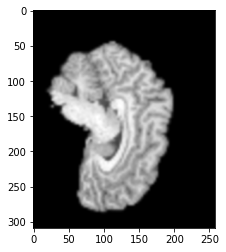

In [77]:
image_name_raw_test = os.path.join('./srcnn/T1w_acpc_dc_restore_brain_102311.nii.gz')
image_test = preprocessing(image_name_raw_test)
hr_test_slice = image_test[120]
lr_test_slice = get_lr(hr_test_slice)
plt.imshow(lr_test_slice, cmap='gray')

## Predict slice

torch.Size([1, 1, 309, 258])


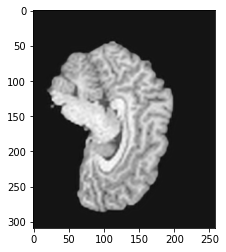

In [85]:
model.eval()
image_test_tensor = ToTensor()(lr_test_slice)
image_test_tensor = torch.unsqueeze(image_test_tensor, 0)
image_test_tensor = image_test_tensor.to(device)
print(image_test_tensor.shape)
output = model(image_test_tensor)

output_test_slice = output.detach().cpu().numpy()[0, 0]

plt.imshow(output_test_slice, cmap='gray')

## Evaluate with metrics

In [87]:
print(peak_signal_noise_ratio(hr_test_slice, lr_test_slice), '\t', structural_similarity(hr_test_slice, lr_test_slice))
print(peak_signal_noise_ratio(hr_test_slice, output_test_slice), '\t', structural_similarity(hr_test_slice, output_test_slice))

26.72662221386675 	 0.9002164638548397
28.264381818075 	 0.9319883502346697
